# Unsteady flow control test case

#### *Paper*:        Real-time optimal control of high-dimensional parametrized systems by deep learning-based reduced order models
#### *Authors*:      M.Tomasetto, A.Manzoni, F.Braghin
#### *Affiliations*: Department of Mechanical Engineering (Politecnico di Milano), MOX - Department of Mathematics (Politecnico di Milano)

In [1]:
#IMPORT LIBRARIES

from dolfin import *
from dolfin_adjoint import *
import gmsh
import torch
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
from __future__ import print_function
from IPython.display import clear_output as clc

from dlroms.cores import CPU, GPU # Cores swapping
import dlroms.fespaces as fe # Finite element spaces handling
import dlroms.geometry as geo # Mesh creation
from dlroms.roms import num2p # Percentage format

set_log_level(LogLevel.ERROR)

In [2]:
# DEFINE THE COLORMAP

from matplotlib import colors
import matplotlib.cm as cm

cmap = cm.get_cmap('terrain_r')
col = [cmap(i) for i in np.linspace(0, 1, 1000)]
col_negative = []
for i in range(1, len(col)):
    col_negative.append([1 - col[i][0], 1 - col[i][1], 1 - col[i][2]])
cmap = colors.LinearSegmentedColormap.from_list("", col_negative)

# State problem

Time-dependent Navier-Stokes equations
\begin{cases}
       \dfrac{\partial \mathbf{v}}{\partial t} -\mu \Delta \mathbf{v} + (\mathbf{v} \cdot \nabla) \mathbf{v} + \nabla p = 0  \qquad &\mathrm{in} \ \Omega \times (0,T] \\
       \mathrm{div }\  \mathbf{v} = 0  \qquad &\mathrm{in} \ \Omega \times (0,T) \\
       \mathbf{v} = \mathbf{u}  \qquad &\mathrm{on} \ \Gamma_{\textrm{c}} \times (0,T)\\
       \mathbf{v} = \boldsymbol{0}  \qquad &\mathrm{on} \ \Gamma_{\textrm{obs}} \times (0,T)\\
       \mathbf{v} = \mathbf{v}_{\text{in}}(\boldsymbol{\mu}_s)  \qquad &\mathrm{on} \ \Gamma_{\textrm{in}} \times (0,T)\\
       \mathbf{v} \cdot \mathbf{n} = 0  \qquad &\mathrm{on} \ \Gamma_{\textrm{walls}} \times (0,T) \\
       (\mu \nabla \mathbf{v} - pI)\mathbf{n} \cdot \mathbf{t} = 0  \qquad &\mathrm{on} \ \Gamma_{\textrm{walls}} \times (0,T) \\
       (\mu \nabla \mathbf{v} - pI)\mathbf{n} = 0  \qquad &\mathrm{on} \ \Gamma_{\textrm{out}} \times (0,T)\\
       \mathbf{v} = \boldsymbol{0} &\mathrm{in} \ \Omega \times \{t = 0\}
\end{cases}

where $\Omega$ is the domain of interest, $T$ is the final time, $\mathbf{v}: \Omega \times [0,T] \to \mathbb R^2$ is the unknown velocity, $p: \Omega \times [0,T] \to \mathbb R$ is the unknown pressure, $\mathbf{u}: \Gamma_c \times [0,T] \to \mathbb R^2$ is the control variable that specifies the Dirichlet boundary condition on the rounded edge of the obstacle $\Gamma_c$, $\mathbf{v}_{\text{in}}: \Gamma_{\textrm{in}} \times [0,T] \to \mathbb R^2$ is the inflow datum depending on scenario parameters $\boldsymbol{\mu}_s$, $\mu$ is the kynematic viscosity, $\mathbf{n}$ and $\mathbf{t}$ are the normal and tangential versors

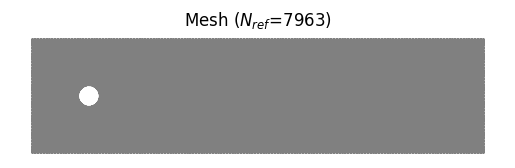

In [3]:
# CREATE THE MESH FOR THE STATE PROBLEM

domain = geo.Rectangle((0, 0), (8, 2)) - geo.Circle((1.0, 1.0), 0.2)
mesh = geo.mesh(domain, stepsize = 0.05)

class AroundCylinders(SubDomain):
    def inside(self, x, on_boundary):
        return (x[0] - 1.0)*(x[0] - 1.0) + (x[1] - 1.0)*(x[1] - 1.0) < 0.3 * 0.3
domains_bool = MeshFunction("bool", mesh, mesh.geometric_dimension())
domains_bool.set_all(False)
AroundCylinders().mark(domains_bool, True)
mesh = refine(mesh, domains_bool)

fe.plot(mesh)
plt.title("Mesh ($N_{ref}$=%d)" % mesh.num_vertices())
plt.show()

In [4]:
# DEFINE SUBDOMAINS AND BOUNDARY PORTIONS FOR THE STATE PROBLEM

dx = Measure("dx", domain = mesh) # Domain measure

class GammaC(SubDomain): # Control boundary
    def inside(self, x, on_boundary):
        return on_boundary and between(x[0], (0.79, 1.0)) and between(x[1], (0.79, 1.21))
class GammaOBS(SubDomain): # Obstacle boundary
    def inside(self, x, on_boundary):
        return on_boundary and between(x[0], (1.0, 1.21)) and between(x[1], (0.79, 1.21))
boundaries_state = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries_state.set_all(0)
GammaC().mark(boundaries_state, 1)
GammaOBS().mark(boundaries_state, 2)
ds = Measure("ds", domain = mesh, subdomain_data = boundaries_state) # Boundary measure

In [5]:
# DEFINE THE STATE SPACE

Vh = FunctionSpace(mesh, VectorElement(NodalEnrichedElement(FiniteElement("CG", mesh.ufl_cell(), 1), FiniteElement("Bubble", mesh.ufl_cell(), 3)))) # Velocity space
Ph = FunctionSpace(mesh, "CG", 1) # Pressure space

nvelocity = Vh.dim() # Velocity space dimension
npressure = Ph.dim() # Pressure space dimension

In [6]:
# GET BOUNDARY INDICES FOR THE CONTROL

bc_dummy = DirichletBC(Vh, (1.0, 2.0), boundaries_state, 1)
fun_dummy = Function(Vh)
bc_dummy.apply(fun_dummy.vector())

idx_control_x = fun_dummy.vector() == 1
idx_control_y = fun_dummy.vector() == 2
idx_control = idx_control_x | idx_control_y

ncontrol = sum(idx_control == True) # Control region dimension

In [7]:
# DEFINE THE STATE PROBLEM SOLVER

from tqdm import tqdm

mu = 0.01
mod_in = 10.0
beta = 1.0
beta_g = 0.2

def boundary_conditions(param):
    # Define boundary conditions (once for all)

    alpha_in = param[0]
    
    # Parabolic BC on the inflow
    v_in = Expression(('mod_in * cos(alpha_in)','x[1] * (2.0 - x[1]) * mod_in * sin(alpha_in)'), degree = 1, mod_in = mod_in, alpha_in = alpha_in)  
    inflow = DirichletBC(Vh, v_in, "on_boundary && x[0] <= 0.01")
   
    # Free-slip BC on the wall
    wall = DirichletBC(Vh.sub(1), 0.0, "on_boundary && (x[1] >= 1.99 || x[1] < 0.01)")

    # Free-slip BC on the wall
    obstacle = DirichletBC(Vh, (0.0, 0.0), boundaries_state, 2)
    
    # BC for the velocity
    bcv = [inflow, wall, obstacle]
    
    # BC for the pressure required by Chorin-Temam method
    bcp = DirichletBC(Ph, 0.0, "on_boundary && x[0] >= 7.99")
    
    return [bcv, bcp]

def chorin_assembly():
    # Assembly for the constant matrices of the Chorin steps (once for all)
    
    w = TestFunction(Vh)
    q = TestFunction(Ph)
    v = TrialFunction(Vh)
    p = TrialFunction(Ph)

    # Second step
    a2 = inner(grad(p), grad(q)) * dx
    A2 = assemble(a2)
    
    # Third step
    a3 = inner(v, w) * dx
    A3 = assemble(a3)
    
    # Fourth step
    a4 = p * q * dx
    A4 = assemble(a4)
    
    return [A2, A3, A4] 
    
def compute_state(param, ut, dt, ntimesteps, v0 = None, p0 = None):
    # Compute state via incremental Chorin-Temam projection method
    # Inputs are the scenario parameters, the control function, the time step, the number of time steps and the initial state 
    # Output is the time-dependent state

    if v0 is None:
        v0 = Function(Vh)
    if p0 is None:
        p0 = Function(Ph)
    
    w = TestFunction(Vh)
    q = TestFunction(Ph)
    v = TrialFunction(Vh)
    p = TrialFunction(Ph)
    v1 = Function(Vh)
    p1 = Function(Ph)
    u = Function(Vh)
          
    [bcv, bcp] = boundary_conditions(param)
    [A2, A3, A4] = chorin_assembly()
    
    vt = CPU.zeros(ntimesteps, nvelocity)
    pt = CPU.zeros(ntimesteps, npressure)

    J = 0.0
    i = 0
    for i in tqdm(range(ntimesteps), colour = "cyan", file = sys.stdout, bar_format = 'Solving state problem |{bar}| {n}/{total} {elapsed}<{remaining}'):

        u.assign(ut[i])
        bc_control = DirichletBC(Vh, u, boundaries_state, 1)
        if i == 0:
            bcv.append(bc_control)
        else:
            bcv[-1] = bc_control
        
        # First Chorin-Temam step
        a1 = (1 / dt) * inner(v, w) * dx + inner(grad(v) * v0, w) * dx + mu * inner(grad(v), grad(w)) * dx 
        A1 = assemble(a1)
        L1 = (1 / dt) * inner(v0, w) * dx - inner(grad(p0), w) * dx
        b1 = assemble(L1)
        [bc.apply(A1, b1) for bc in bcv]
        solve(A1, v1.vector(), b1)
        
        # Second Chorin-Temam step
        L2 = - (1 / dt) * div(v1) * q * dx
        b2 = assemble(L2)
        bcp.apply(A2, b2)
        solve(A2, p1.vector(), b2)
        
        # Third Chorin-Temam step
        L3 = inner(v1, w) * dx - dt * inner(grad(p1), w) * dx
        b3 = assemble(L3)
        solve(A3, v1.vector(), b3)
        
        # Fourth Chorin-Temam step
        L4 = p0 * q * dx + p1 * q * dx
        b4 = assemble(L4)
        solve(A4, p1.vector(), b4)

        grad_u = grad(u)
        norm_grad_u = sum(abs(grad_u[i, j]) for i in range(mesh.geometry().dim()) for j in range(mesh.geometry().dim()))
        J += assemble(0.5 * inner(grad(v1), grad(v1)) * dx + 0.5 * beta * inner(u, u) * ds(1) + 0.5 * beta_g * norm_grad_u * ds(1))

        v0.assign(v1)
        p0.assign(p1)
        vt[i] = CPU.tensor(v1.vector())
        pt[i] = CPU.tensor(p1.vector())
        i = i + 1
    
    return [vt, pt, J]

In [8]:
# SOLVE THE STATE PROBLEM SOLVER

dt = Constant(0.1)
T = 4.5
ntimesteps = round(T / dt)

ut = [] # Time-dependent control
for i in range(ntimesteps):
    ut.append(Function(Vh)) # Set the control for each time-step

[vt, pt, J] = compute_state([1.0], ut, dt, ntimesteps)

set_working_tape(Tape());

Solving state problem |██████████████████████████████████████| 45/45 00:26<00:00


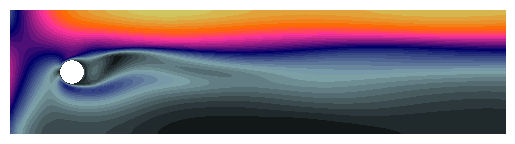

In [9]:
# VELOCITY TRAJECTORY

import imageio

def trajectory_velocity(vt, save = False, name = None):

    arrays = []
    
    for i in range(vt.shape[0]):
        plt.figure()
        v_plot = Function(Vh)
        v_plot.vector()[:] = vt[i]
        v_norm = project(sqrt(inner(v_plot, v_plot)), Vh.sub(1).collapse())  
        plot(v_norm, cmap = cmap)
        plt.axis('off')
        fig = plt.gcf()
        display(fig)
        if save:
            arrays.append(np.array(fig.canvas.renderer.buffer_rgba()))
        plt.close()
        clc(wait=True)

    if save:
        imageio.mimsave(name.replace(".gif", "") + ".gif", arrays)

trajectory_velocity(vt)

# Snapshots generation

### PDE-constrained Optimisation

Consider the problem of minimising the energy dissipation

$$
\min_{\boldsymbol{v},p,\boldsymbol{u}} \frac{1}{2} \int_0^T \int_{\Omega} ||\nabla \boldsymbol{v}||^2 + \frac{\beta}{2} \int_0^T \int_{\Gamma_{\textrm{c}}} ||\boldsymbol{u}||^2 + \dfrac{\beta_g}{2} \int_0^T \int_{\Gamma_{\textrm{c}}} ||\nabla \boldsymbol{u}||_{L^1} \\
$$

Physically, this setup corresponds to minimising the loss of flow energy into heat by actively controlling the inflow/outflow at a portion of the obstacle boundary. To avoid excessive and irregular control solutions, non-zero and non-constant control values are penalised via the regularisation terms.

In [18]:
# GENERATE SNAPSHOTS (SKIP THIS CELL IF DATA ALREADY AVAILABLE)

from dlroms.ocp import snapshots

dt = Constant(0.1)
T = 4.5
ntimesteps = round(T / dt)
burnin_timesteps = 5

nsnapshots = 50
ntrain = 40
ntrain *= ntimesteps
nparams = 2

ranges = [(-1.0, 1.0)] # Scenario paramters: alpha_in

set_working_tape(Tape()) # Reset forward model annotated by dolfin adjoint 

def sampler(seed):
    """
    Generate a random sample of scenario parameters and the corresponding optimal pair
    Input: seed
    Output: scenario parameters, optimal state and control
    """
    params = [0] * len(ranges)
    for i in range(len(ranges)):
        params[i] = ((ranges[i][1] - ranges[i][0]) * CPU.rand() + ranges[i][0]).item()    

    v0 = Function(Vh)
    p0 = Function(Ph)
    ut = OrderedDict()
    ut = []
    for j in range(ntimesteps):
        ut.append(Function(Vh)) # Initialize one control for each time-step

    # Burn-in
    [vt, pt, J] = compute_state(params, ut, dt, burnin_timesteps, v0, p0)
    set_working_tape(Tape());
    v0 = Function(Vh)
    v0.vector()[:] = vt[-1]
    p0 = Function(Ph)
    p0.vector()[:] = pt[-1]
    
    v0_copy = v0.copy(deepcopy = True) # Copy v0 since it will be modified in compute_state
    p0_copy = p0.copy(deepcopy = True) # Copy p0 since it will be modified in compute_state
    
    [vt, pt, J] = compute_state(params, ut, dt, ntimesteps, v0, p0)
    
    control = [Control(u) for u in ut]
    Jhat = ReducedFunctional(J, control)
    ut_opt = minimize(Jhat, method = 'L-BFGS-B', options = {'disp': True, 'maxiter': 100})

    [vt_opt, pt_opt, J_opt] = compute_state(params, ut_opt, dt, ntimesteps, v0_copy, p0_copy)

    set_working_tape(Tape())    

    ut_opt_vals = CPU.zeros(ntimesteps, ncontrol)
    params_vals = CPU.zeros(ntimesteps, nparams)
    for j in range(ntimesteps):
        ut_opt_vals[j] = CPU.tensor(ut_opt[j].vector()[idx_control])
        params_vals[j,0:(nparams - 1)] = CPU.tensor(params)
        params_vals[j,(nparams - 1):] = (j + 1) * float(dt)

    return params_vals, vt_opt, ut_opt_vals

snapshots(nsnapshots, sampler, core = CPU, verbose = True, filename = 'Data/UnsteadyNavier-Stokes')

In [10]:
# LOAD SNAPSHOTS MATRICES

dt = Constant(0.1)
T = 4.5
ntimesteps = round(T / dt)

nsnapshots = 100
ntrain = 80
ntrain *= ntimesteps
nparam = 2

ranges = [(-1.0, 1.0)] # Scenario paramters: alpha_in

filename = 'Data/UnsteadyNavier-Stokes'
Data = np.load("%s.npz" % filename.replace(".npz",""))

MU = CPU.tensor(Data["mu"])
V = CPU.tensor(Data["y"])
U = CPU.tensor(Data["u"])

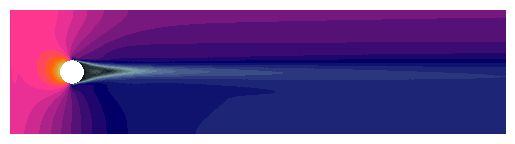

In [11]:
# VELOCITY TRAJECTORY EXAMPLE

whichtrajectory = 0

trajectory_velocity(V[whichtrajectory])

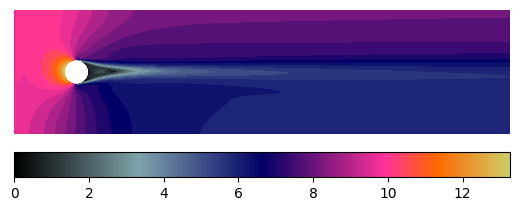

In [12]:
# VELOCITY SNAPSHOT EXAMPLE

whichtrajectory = 0
whichtime = -1

def plot_velocity(v, colorbar = False):
    v_plot = Function(Vh)
    v_plot.vector()[:] = v
    v_norm = project(sqrt(inner(v_plot, v_plot)), Vh.sub(1).collapse())  
    
    fig_dummy = plot(v_norm, cmap = cmap, vmin = 0.0, mode = "color")
    plot(v_norm, cmap = cmap)

    plt.axis('off')

    if colorbar:
        plt.colorbar(fig_dummy, orientation = "horizontal", pad = 0.05)
    
plot_velocity(V[whichtrajectory, whichtime], colorbar = True)

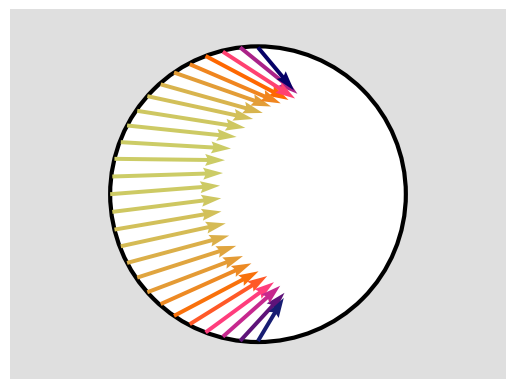

In [14]:
# CONTROL TRAJECTORY EXAMPLE

import matplotlib.patches as patches

whichtrajectory = 0

def trajectory_control(ut, save = False, name = None):

    arrays = []

    for i in range(ut.shape[0]):
        plt.figure()
        u_plot = CPU.zeros(nvelocity)
        u_plot[idx_control] = ut[i]
        u_plot = fe.asvector(u_plot, Vh)
        
        rectangle = patches.Rectangle((0.0, 0.0), 8.0, 2.0, edgecolor = 'silver', facecolor = 'silver', alpha = 0.5, zorder = 0)
        circle = patches.Circle((1, 1), 0.2, edgecolor = 'black', facecolor = 'white', linewidth = 3, zorder = 0)
        plt.gca().add_patch(rectangle)
        plt.gca().add_patch(circle)
        plot(u_plot, scale = 60, cmap = cmap, minlength = 0, width = 0.008)
        
        plt.axis('equal')
        plt.axis('off')
        plt.xlim((0.75, 1.25))
        plt.ylim((0.75, 1.25))
        fig = plt.gcf()
        display(fig)
        if save:
            arrays.append(np.array(fig.canvas.renderer.buffer_rgba()))
        plt.close()
        clc(wait=True)
  
    if save:
        imageio.mimsave(name.replace(".gif", "") + ".gif", arrays)

trajectory_control(U[whichtrajectory])

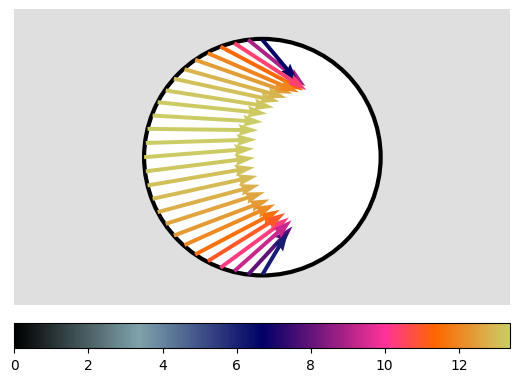

In [15]:
# CONTROL SNAPSHOT EXAMPLE

whichtrajectory = 0
whichtime = -1

def plot_control(u, colorbar = False):
    u_plot = CPU.zeros(nvelocity)
    u_plot[idx_control] = u
    u_plot = fe.asvector(u_plot, Vh)
        
    rectangle = patches.Rectangle((0.0, 0.0), 8.0, 2.0, edgecolor = 'silver', facecolor = 'silver', alpha = 0.5, zorder = 0)
    circle = patches.Circle((1, 1), 0.2, edgecolor = 'black', facecolor = 'white', linewidth = 3, zorder = 0)
    plt.gca().add_patch(rectangle)
    plt.gca().add_patch(circle)
    fig = plot(u_plot, scale = 60, cmap = cmap, minlength = 0, width = 0.008)
        
    plt.axis('equal')
    plt.axis('off')
    plt.xlim((0.75, 1.25))
    plt.ylim((0.75, 1.25))

    if colorbar:
        plt.colorbar(fig, orientation = "horizontal", pad = 0.05)
        
plot_control(U[whichtrajectory, whichtime], colorbar = True)

In [16]:
# RESHAPE MATRICES

V = V.reshape(-1, nvelocity)
U = U.reshape(-1, ncontrol)
MU = MU.reshape(-1, nparam)

In [17]:
# SPLIT MATRICES OF VECTORIAL FIELD

Vx = V[:, 0 : nvelocity : 2]
Vy = V[:, 1 : nvelocity : 2]

In [18]:
# CREATE MATRICES WITH CONTROL ON THE ENTIRE DOMAIN TO COMPUTE ERRORS

Ux_extended = CPU.zeros(nsnapshots * ntimesteps, nvelocity // 2)
Uy_extended = CPU.zeros(nsnapshots * ntimesteps, nvelocity // 2)
Ux_extended[:,idx_control_x[0 : nvelocity : 2]] = U[:, ::2]
Uy_extended[:,idx_control_y[1 : nvelocity : 2]] = U[:, 1::2]

# POD-DL-ROM

In [19]:
# IMPORT FUNCTIONS FOR POD AND NEURAL NETWORKS

from dlroms.dnns import Dense, Weightless # Neural networks handling
from dlroms.roms import projectup, mre, mse, euclidean # Proper orthogonal decomposition
from dlroms.ocp import L2 # Error metric

l2_state = L2(mesh, Vh, measure = dx, core = CPU)
l2_control = L2(mesh, Vh, measure = ds(1), core = CPU)

mse = mse(euclidean)
mre = mre(euclidean)

In [20]:
# DEFINE THE OCP OBJECT TO HANDLE REDUCTIONS AND PREDICTIONS

from dlroms.ocp import OCP

ocp = OCP(ntrain)

## State reduction - POD+AE

In [23]:
# POD+AE for Vx

k_Vx = 100 # Number of POD modes
n_Vx = 20 # Latent dimension
encoder_Vx = Dense(k_Vx, 50) + Dense(50, n_Vx)
decoder_Vx = Dense(n_Vx, 50) + Dense(50, 50) + Dense(50, k_Vx, activation = None)

Vx_DLROM, Vx_reconstructed, pod_Vx, eig_Vx = ocp.PODAE(Vx, k = k_Vx, encoder = encoder_Vx, decoder = decoder_Vx, training = False, save = False, path = 'NN/UnsteadyFlowControl/autoencoder_Vx.pt', decay = False, epochs = 100, optim = torch.optim.LBFGS, loss = mse, error = mre, best = True)

In [24]:
# POD+AE for Vy

k_Vy = 100 # Number of POD modes
n_Vy = 20 # Latent dimension
encoder_Vy = Dense(k_Vy, 50) + Dense(50, n_Vy)
decoder_Vy = Dense(n_Vy, 50) + Dense(50, 50) + Dense(50, k_Vy, activation = None)

Vy_DLROM, Vy_reconstructed, pod_Vy, eig_Vy = ocp.PODAE(Vy, k = k_Vy, encoder = encoder_Vy, decoder = decoder_Vy, training = False, save = False, path = 'NN/UnsteadyFlowControl/autoencoder_Vy.pt', decay = False, epochs = 100, optim = torch.optim.LBFGS, loss = mse, error = mre, best = True)

In [25]:
# POD+AE RECONSTRUCTION ERRORS ON TEST DATA

print("POD+AE reconstruction errors:")
print("")
print("L2 mean relative error on V: %s." % num2p(l2_state.mre_vect(Vx[ntrain:], Vx_reconstructed[ntrain:], Vy[ntrain:], Vy_reconstructed[ntrain:])))

POD+AE reconstruction errors:

L2 mean relative error on V: 2.31%.


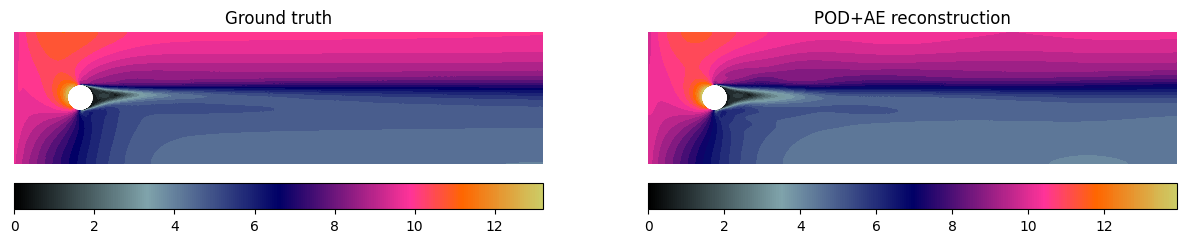

In [27]:
# FOM vs POD+AE (PLOTS)

which = -1

V_reconstructed = CPU.zeros(nsnapshots * ntimesteps, nvelocity)
V_reconstructed[:, 0 : nvelocity : 2] = Vx_reconstructed
V_reconstructed[:, 1 : nvelocity : 2] = Vy_reconstructed

plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plot_velocity(V[which], colorbar = True)
plt.title("Ground truth");

plt.subplot(1,2,2)
plot_velocity(V_reconstructed[which], colorbar = True)
plt.title("POD+AE reconstruction");

## Control reduction - POD

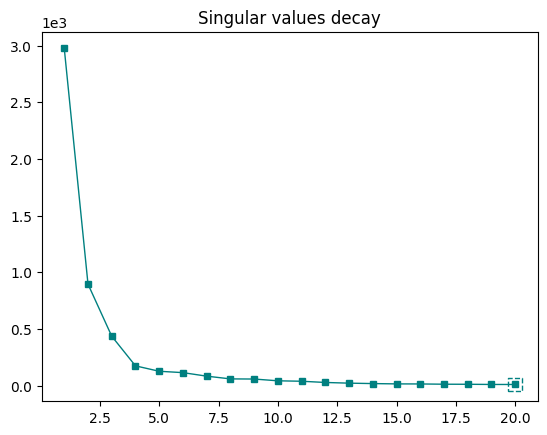

In [28]:
# PROPER ORTHOGONAL DECOMPOSITION FOR U

n_U = k_U = 20 # Number of POD modes

U_POD, U_reconstructed, pod_U, eig_U = ocp.POD(U, k = k_U, color = "teal")

In [29]:
# POD+AE reconstruction errors on test data

U_POD_reconstruction = projectup(pod_U, U_POD)

Ux_POD_reconstruction_extended = CPU.zeros(nsnapshots * ntimesteps, nvelocity // 2)
Uy_POD_reconstruction_extended = CPU.zeros(nsnapshots * ntimesteps, nvelocity // 2)
Ux_POD_reconstruction_extended[:,idx_control_x[0 : nvelocity : 2]] = U_POD_reconstruction[:, ::2]
Uy_POD_reconstruction_extended[:,idx_control_y[1 : nvelocity : 2]] = U_POD_reconstruction[:, 1::2]

print("POD errors:")
print("")
print("L2 mean relative error on U: %s." % num2p(l2_control.mre_vect(Ux_extended[ntrain:], Ux_POD_reconstruction_extended[ntrain:], Uy_extended[ntrain:], Uy_POD_reconstruction_extended[ntrain:])))

POD errors:

L2 mean relative error on U: 0.35%.


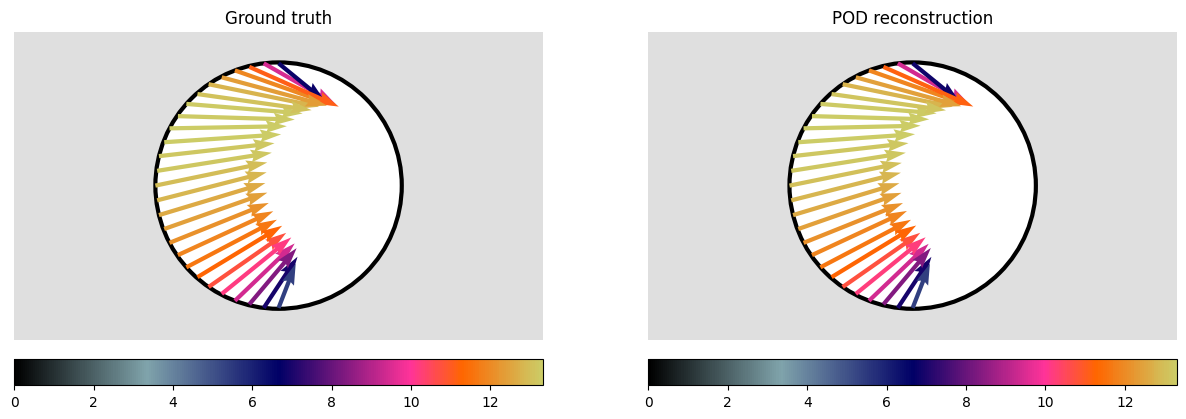

In [31]:
# FOM vs POD (PLOTS)

which = -1

plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plot_control(U[which], colorbar = True)
plt.title("Ground truth");

plt.subplot(1,2,2)
plot_control(U_POD_reconstruction[which], colorbar = True)
plt.title("POD reconstruction");

## Parameter-to-solution map $\boldsymbol{\mu}_s \to (\mathbf{y}_{POD+AE} )$ 


In [33]:
# NN TO MAP PARAMETERS IN REDUCED OPTIMAL STATE AND CONTROL

nembedd = 4
class Embedd(Weightless): # First layer with some fixed transformation of the input (driven by the problem)
    def forward(self, x):
        return torch.cat([x, x[:,[0]].sin(), x[:,[0]].cos(), (x[:,[0]]*x[:,[1]]).cos(), (x[:,[0]]*x[:,[1]]).sin()], axis = 1)

phi_V = Embedd() + Dense(nparam + nembedd, 50) + Dense(50, 50) + Dense(50, n_Vx + n_Vy, activation = None)

V_DLROM = [Vx_DLROM, Vy_DLROM]

V_DLROM_hat = ocp.redmap(phi_V, MU, V_DLROM, minmax = False, training = False, save = False, path = 'NN/UnsteadyFlowControl/phi_V.pt', epochs = 500, optim = torch.optim.LBFGS, loss = mse, error = mre, best = True)

In [40]:
# POD-DL-ROM PREDICTION ERRORS ON TEST DATA

Vx_DLROM_hat = V_DLROM_hat[0]
Vy_DLROM_hat = V_DLROM_hat[1]

Vx_hat = projectup(pod_Vx, decoder_Vx(Vx_DLROM_hat))
Vy_hat = projectup(pod_Vy, decoder_Vy(Vy_DLROM_hat))

print("POD-DL-ROM prediction errors:")
print("")
print("L2 mean relative error on V: %s." % num2p(l2_state.mre_vect(Vx[ntrain:], Vx_hat[ntrain:], Vy[ntrain:], Vy_hat[ntrain:])))

POD-DL-ROM prediction errors:

L2 mean relative error on V: 5.25%.


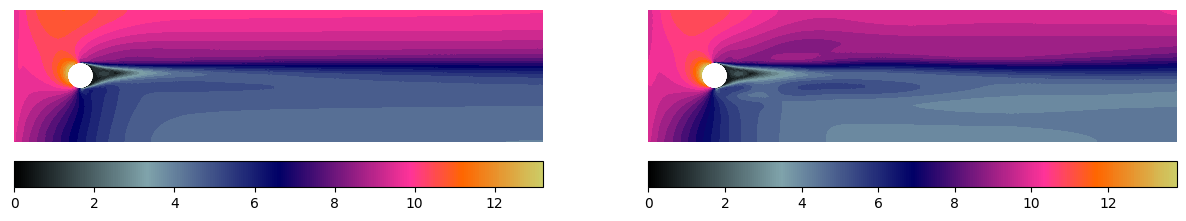

In [42]:
# FOM vs POD-DL-ROM (PLOTS)

which = -1

V_hat = CPU.zeros(nsnapshots * ntimesteps, nvelocity)
V_hat[:, 0 : nvelocity : 2] = Vx_hat
V_hat[:, 1 : nvelocity : 2] = Vy_hat

plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plot_velocity(V[which], colorbar = True)

plt.subplot(1,2,2)
plot_velocity(V_hat[which], colorbar = True)

## Parameter-to-solution map $\boldsymbol{\mu}_s \to (\mathbf{u}_{POD} )$ 


In [43]:
# NN TO MAP PARAMETERS IN REDUCED OPTIMAL STATE AND CONTROL

nembedd = 4
class Embedd(Weightless): # First layer with some fixed transformation of the input (driven by the problem)
    def forward(self, x):
        return torch.cat([x, x[:,[0]].sin(), x[:,[0]].cos(), (x[:,[0]]*x[:,[1]]).cos(), (x[:,[0]]*x[:,[1]]).sin()], axis = 1)

phi_U = Embedd() + Dense(nparam + nembedd, 50) + Dense(50, 50) + Dense(50, n_U, activation = None)

U_POD_hat = ocp.redmap(phi_U, MU, [U_POD], minmax = False, training = False, save = False, path = 'NN/UnsteadyFlowControl/phi_U.pt', epochs = 500, optim = torch.optim.LBFGS, loss = mse, error = mre, best = True)

In [44]:
# POD-NN PREDICTION ERRORS ON TEST DATA

U_hat = projectup(pod_U, U_POD_hat[0])

Ux_hat_extended = CPU.zeros(nsnapshots * ntimesteps, nvelocity // 2)
Uy_hat_extended = CPU.zeros(nsnapshots * ntimesteps, nvelocity // 2)
Ux_hat_extended[:,idx_control_x[0 : nvelocity : 2]] = U_hat[:,::2]
Uy_hat_extended[:,idx_control_y[1 : nvelocity : 2]] = U_hat[:,1::2]

print("POD-NN prediction errors:")
print("")
print("L2 mean relative error on U: %s." % num2p(l2_control.mre_vect(Ux_extended[ntrain:], Ux_hat_extended[ntrain:], Uy_extended[ntrain:], Uy_hat_extended[ntrain:])))

POD-NN prediction errors:

L2 mean relative error on U: 2.45%.


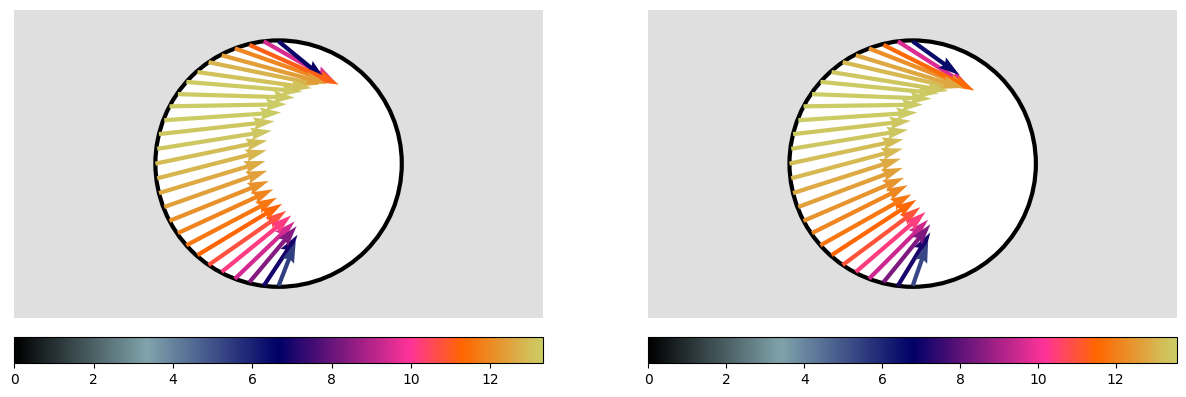

In [46]:
# FOM vs POD-NN (PLOTS)

which = -1

plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plot_control(U[which], colorbar = True)

plt.subplot(1,2,2)
plot_control(U_hat[which], colorbar = True)

## Test case: solve the unsteady OCP for a fixed angle of attack

In [47]:
# CREATE TEST PARAMETERS

alpha_in_test = -0.75
dt_test = Constant(0.1)
T_test = 4.5
ntimesteps_test = round(T_test / dt_test)

MU_test = CPU.zeros(ntimesteps_test, nparam)

for j in range(ntimesteps_test):
    MU_test[j,0] = alpha_in_test
    MU_test[j,1] = (j + 1) * float(dt_test)

In [48]:
# PREDICT OPTIMAL STATE AND CONTROL

V_DLROM_hat = phi_V(MU_test)
Vx_DLROM_hat = V_DLROM_hat[:,:n_Vx]
Vy_DLROM_hat = V_DLROM_hat[:,n_Vx:]
U_POD_hat = phi_U(MU_test)

Vx_test_hat = projectup(pod_Vx, decoder_Vx(Vx_DLROM_hat))
Vy_test_hat = projectup(pod_Vy, decoder_Vy(Vy_DLROM_hat))
U_test_hat = projectup(pod_U, U_POD_hat)

V_test_hat = CPU.zeros(ntimesteps_test, nvelocity)
V_test_hat[:, 0 : nvelocity : 2] = Vx_test_hat
V_test_hat[:, 1 : nvelocity : 2] = Vy_test_hat

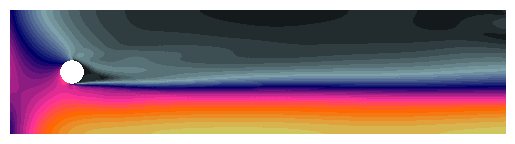

In [49]:
# POD-DL-ROM VELOCITY PREDICTION

trajectory_velocity(V_test_hat)

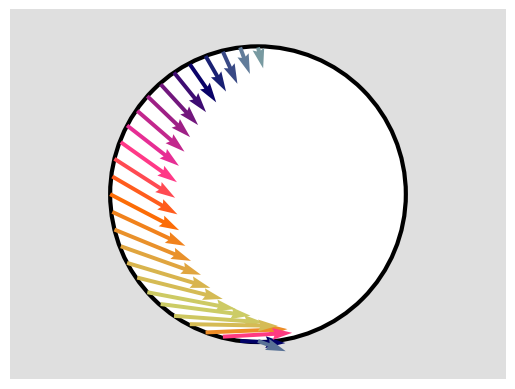

In [50]:
# POD-NN CONTROL PREDICTION

trajectory_control(U_test_hat)

In [51]:
# APPLY PREDICTED CONTROL TO THE SYSTEM

# Burn-in
burnin_timesteps = 5
ut = []
for j in range(burnin_timesteps):
    u = Function(Vh)
    ut.append(u)

[vt, pt, J] = compute_state([alpha_in_test], ut, dt, burnin_timesteps)

# Controlled dynamics
v0 = Function(Vh)
v0.vector()[:] = vt[-1]
p0 = Function(Ph)
p0.vector()[:] = pt[-1]
ut = []
for j in range(ntimesteps_test):
    uvec = CPU.zeros(nvelocity)
    uvec[idx_control] = U_test_hat[j]
    u = Function(Vh)
    u.vector()[:] = uvec
    ut.append(u)

[V_test, P_test, J_test] = compute_state([alpha_in_test], ut, dt_test, ntimesteps_test)

Solving state problem |████████████████████████████████████████| 5/5 00:02<00:00
Solving state problem |██████████████████████████████████████| 45/45 00:26<00:00


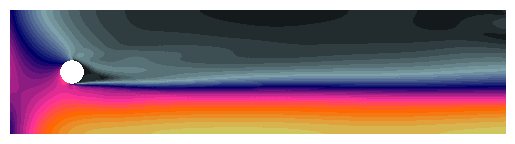

In [52]:
# CONTROLLED VELOCITY

trajectory_velocity(V_test_hat)